In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import repaint_sampling as RS
import repaint_patcher as RP
import prepare_glide_inpaint as PGI
from image_util import *

In [3]:
import torch as th

In [52]:
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda:2')

In [53]:
model, diffusion, options = PGI.create_glide_generative(device=device, cuda=has_cuda)
model_up, diffusion_up, options_up = PGI.create_glide_upsampler(device=device, cuda=has_cuda)

/home/infres/kbrowder-24/jp/CSC_52002_EP_Generative_AI_Project/glide-text2im-main/glide_text2im/download.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(

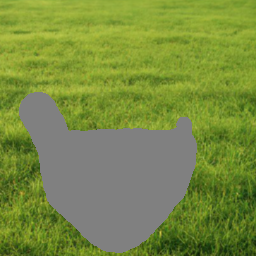

In [72]:
# Sampling parameters
prompt = "a monkey in a field"
batch_size = 1
guidance_scale = 5.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

# src_img_path = 'RePaint-main/data/datasets/gts/face/000000.png'
src_img_path = 'glide-text2im-main/notebooks/grass.png'

# Source image we are inpainting
source_image_256 = read_image(src_img_path, size=256)
source_image_64 = read_image(src_img_path, size=64)

src_mask_path = 'RePaint-main/data/datasets/gt_keep_masks/face/000000.png'

# The mask should always be a boolean 64x64 mask, and then we
# can upsample it for the second stage.
source_mask_64 = read_mask(src_mask_path, size=64)
source_mask_256 = read_mask(src_mask_path, size=256)

# Visualize the image we are inpainting
show_images(source_image_256 * source_mask_256)

# Starting With Glide Inpainting

In [ ]:
base_sampler = RS.CFGSamplerInpaint(model, diffusion, options, guidance_scale, device=device)
samples = base_sampler.sample(source_image_64, source_mask_64, prompt, batch_size)
samples = samples[:batch_size]

100%|██████████| 250/250 [00:33<00:00,  7.51it/s]


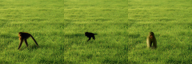

In [62]:
show_images(samples)

In [ ]:
upscale_sampler = RS.UpscaleSamplerInpaint(model_up, diffusion_up, options_up, model_fn=None, device=device)
upsamples = upscale_sampler.sample(samples, upsample_temp, source_image_256, source_mask_256, prompt, batch_size)
upsamples = upsamples[:batch_size]

100%|██████████| 250/250 [01:03<00:00,  3.92it/s]


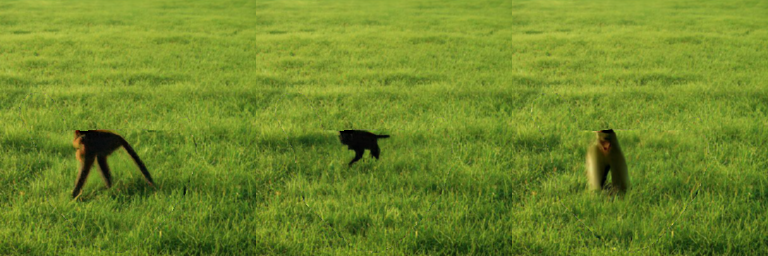

In [64]:
show_images(upsamples)

# Now With Repaint

In [88]:
from copy import deepcopy

diffusion_rp = deepcopy(diffusion)
diffusion_rp_up = deepcopy(diffusion_up)

RP.patch_model_for_repaint(diffusion_rp)
RP.patch_model_for_repaint(diffusion_rp_up)

jump_params = {
    "t_T": 250,
    "n_sample": 1,
    "jump_length": 10,
    "jump_n_sample": 10
}

In [89]:
base_sampler = RS.CFGSamplerRepaint(model, diffusion_rp, options, guidance_scale, device=device)
samples = base_sampler.sample(source_image_64, source_mask_64, prompt, batch_size, jump_params=jump_params)
samples = samples[:batch_size]

  0%|          | 0/4570 [00:00<?, ?it/s]

100%|██████████| 4570/4570 [02:08<00:00, 35.45it/s]


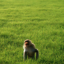

In [90]:
show_images(samples)

In [91]:
upscale_sampler = RS.UpscaleSamplerRepaint(model_up, diffusion_rp_up, options_up, model_fn=None, device=device)
upsamples = upscale_sampler.sample(samples, upsample_temp, source_image_256, source_mask_256, prompt, batch_size, jump_params=jump_params)
upsamples = upsamples[:batch_size]

100%|██████████| 4570/4570 [02:51<00:00, 26.68it/s]


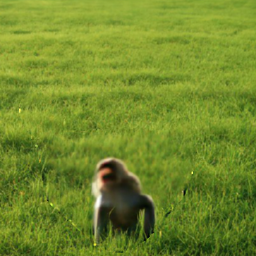

In [92]:
show_images(upsamples)

# Now With Both Repaint and Inpainting

In [93]:
base_sampler = RS.CFGSamplerRepaintInpaint(model, diffusion_rp, options, guidance_scale, device=device)
samples = base_sampler.sample(source_image_64, source_mask_64, prompt, batch_size, jump_params=jump_params)
samples = samples[:batch_size]

100%|██████████| 4570/4570 [02:08<00:00, 35.65it/s]


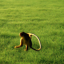

In [94]:
show_images(samples)

In [95]:
upscale_sampler = RS.UpscaleSamplerRepaintInpaint(model_up, diffusion_rp_up, options_up, model_fn=None, device=device)
upsamples = upscale_sampler.sample(samples, upsample_temp, source_image_256, source_mask_256, prompt, batch_size, jump_params=jump_params)
upsamples = upsamples[:batch_size]

100%|██████████| 4570/4570 [02:50<00:00, 26.78it/s]


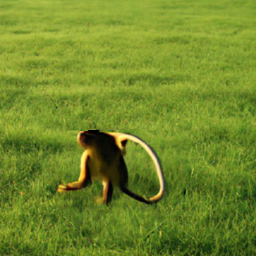

In [96]:
show_images(upsamples)